In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from PIL import Image

In [2]:
def create_artboard(rows, cols):
    return np.zeros([rows, cols])

def create_empty_target(rows, cols):
    return np.zeros([rows, cols])

In [4]:
def process_pic(image_path, target_width=300):
    
#     open image and convert to grayscale. image can be jpeg or png
    processed_pic = Image.open(image_path).convert('L')

#     resize image to match specified width while maintaining ratio
    basewidth = target_width
    wpercent = (basewidth/float(processed_pic.size[0]))
    hsize = int((float(processed_pic.size[1])*float(wpercent)))
    processed_pic = processed_pic.resize((basewidth, hsize), Image.ANTIALIAS)
    
#     convert to numpy array
    processed_pic = np.asarray(processed_pic)
    
    print('shape:', processed_pic.shape)
    
    return processed_pic

In [9]:
def add_random_variable_rectangle_and_report_change_locations(artboard, rect_rows, rect_cols):
    
#     get relative locations of all values to be written, where 0, 0 is top left location
    cell_positions_from_top_left = []
    
    for i in range(rect_rows):
        for j in range(rect_cols):
            cell_positions_from_top_left.append((i, j))

    artboard_rows = len(artboard)
    artboard_cols = len(artboard[0])

    ## pick a random cell in the artboard that is not on the border
    random_row = random.randint(0, artboard_rows - rect_rows)
    random_col = random.randint(0, artboard_cols - rect_cols)

    ## modify and record locations of all of its neighbors
    locations = []
    for relative_position in cell_positions_from_top_left:
        absolute_row = relative_position[0] + random_row
        absolute_col = relative_position[1] + random_col
        if artboard[absolute_row][absolute_col] < 215:
            artboard[absolute_row][absolute_col] += 40
            locations.append((absolute_row, absolute_col))
            
    
    return artboard, locations

In [10]:
def score(artboard, target, locations=None):
    
#     print('scoring')
    
    score = 0
    max_score = len(artboard) * len(artboard[0])
#     max score is one point per cell
    
    rows = len(artboard)
    cols = len(artboard[0])
    
    if rows != len(target) or cols != len(target[0]):
#         print('errorrr')
        return 'target and artboard are not the same size!'
    
    total_percent_difference = 0
    
#     for each cell, calculate percent difference between target and artboard by taking min(target, artboard)/max(target, artboard)
    
    if not locations:
#         print('no locations!')
        for i, row in enumerate(artboard):
            for j, col in enumerate(row):
                target_value = target[i][j]
                artboard_value = artboard[i][j]
#                 total_percent_difference = abs(target_value - artboard_value)/target_value
#                 total_percent_difference += min(target_value, artboard_value)/max(target_value, artboard_value)
#                 print(target_value, artboard_value)
                squared_difference = (target_value - artboard_value)**2
    else:
#         print('got locations')
        for pair in locations:
#             print('scoring', pair)
            target_value = target[pair[0]][pair[1]]
            artboard_value = artboard[pair[0]][pair[1]]
#             total_percent_difference += abs(artboard[pair[0]][pair[1]] - target[pair[0]][pair[1]])
#             total_percent_difference += (1 - abs(artboard[pair[0]][pair[1]] - target[pair[0]][pair[1]])/255)
#             print('TPD: ', total_percent_difference)
            squared_difference = (artboard[pair[0]][pair[1]] - target[pair[0]][pair[1]])**2
    
    score = squared_difference * -1
    
#     print(score)
    
    return score

In [11]:
def draw(artboard, target, rect_rows, rect_cols, iterations):
    """generate a number (iterations) of artboards with random shapes drawn and pick the highest scoring one to keep"""
    
    result = copy.deepcopy(artboard)
#     print('copied artboard')
    
#     get current artboard score to evaluate against
#     current_score = score(artboard, target)
    count_added = 0
    
    for i in range(iterations):
#         print('iterating')
        
    #     create a temporary artboard
        temp_artboard = copy.deepcopy(result)
        
    #     add random rectangle to temp artboard
        temp_artboard, locations = add_random_variable_rectangle_and_report_change_locations(temp_artboard, rect_rows=rect_rows, rect_cols=rect_cols)
        
    #     see if that square made an improvement. if so, assign temp_artboard to artboard
#         if score(temp_artboard, target, locations) > current_score:
        if score(temp_artboard, target, locations) > score(artboard, target, locations):
#             print('random addition is improvement')
            result = copy.deepcopy(temp_artboard)
            current_score = score(temp_artboard, target, locations)
            count_added += 1
    
#     print('previous score: ', score(artboard, target))
#     print('current score: ', current_score)
#     print('total added: ', count_added)
#     print('percent improvement: ', ((1 - current_score/score(artboard, target)) * 100))
    
    return result

# Let's make some art!

In [21]:
tim_pic = process_pic('tim_trees.jpg')

('shape:', (225, 300))


In [37]:
tim_artboard = create_artboard(225, 300)

In [41]:
tim_artboard = draw(artboard=tim_artboard, target=tim_pic, rect_rows=2, rect_cols=2, iterations=1000)

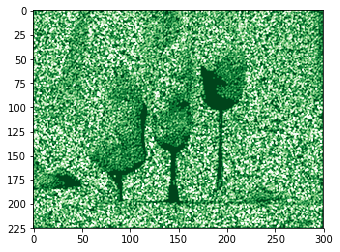

In [42]:
plt.imshow(tim_artboard, cmap="Greens")

In [39]:
for i, row in enumerate(tim_artboard):
    for j, value in enumerate(row):
        tim_artboard[i][j] = 255 - value

In [44]:
shea_pic = process_pic('shea-coulee.png')

('shape:', (198, 300))


In [62]:
shea_artboard = create_artboard(198, 300)

In [95]:
shea_artboard = draw(artboard=shea_artboard, target=shea_pic, rect_rows=6, rect_cols=6, iterations=100)

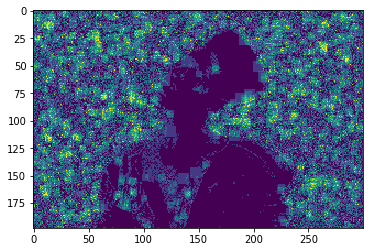

In [96]:
plt.imshow(shea_artboard)

In [98]:
topo_pic = process_pic('jeff-topo-pic-2.jpg')

('shape:', (400, 300))


In [99]:
topo_artboard = create_artboard(400, 300)

In [116]:
topo_artboard = draw(artboard=topo_artboard, target=topo_pic, rect_rows=2, rect_cols=2, iterations=10000)

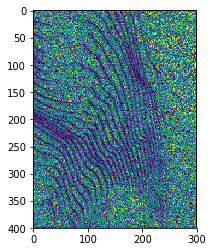

In [117]:
plt.imshow(topo_artboard)